In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cProfile
from scipy import linalg
import scipy as sp

### Schemat Hornera

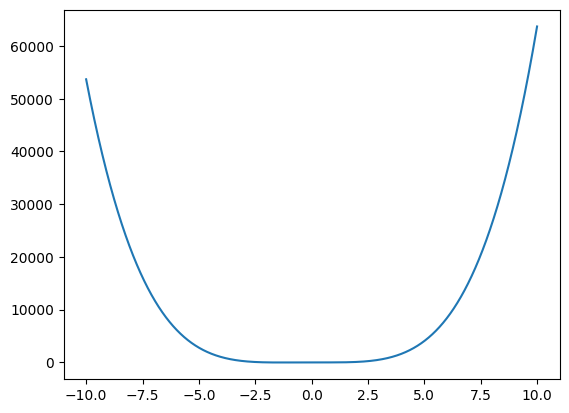

[53691.         53688.77613437 53686.55233748 ... 63703.42803515
 63705.9519483  63708.47593619]


In [3]:
def eval_pol(x, coeff):
    p = coeff[-1]
    n = len(coeff)
    for i in range(1, n):
        p = coeff[n-i-1] + p*x
    return p

xs = np.arange(-10,10,0.0001)
ys = eval_pol(xs, [1,1,-13,5,6])
plt.plot(xs, ys)
plt.show()
print(ys)

## Rozwiązywanie układów równań:

### 1. Metoda eliminacji Gaussa

In [6]:
def partial_elimination(A,b):
    A = np.array(A).astype(float)
    b = np.array(b).astype(float)
    n = len(b)
    row_idx = 0
    col_idx = 0
    for i in range(n-1):
        col_nums = []
        col_nums.append(A[row_idx:,i])
        col_max = np.max(col_nums)
        pivot_row = np.argwhere(A[:,col_idx]==col_max)[-1][0]
        A[[row_idx, pivot_row]] = A[[pivot_row, row_idx]]
        b[[row_idx, pivot_row]] = b[[pivot_row, row_idx]]
        for k in range(row_idx, n-1):
            lam = A[k+1,col_idx]/A[row_idx,col_idx]
            A[k+1, :] = A[k+1, :] - lam*A[row_idx, :]
            b[k+1] = b[k+1] - lam*b[row_idx]
        row_idx += 1
        col_idx += 1  
    for k in range(n-1,-1,-1):
        b[k] = (b[k] - np.dot(A[k,k+ 1:n],b[k+ 1:n]))/A[k,k] 
    return A, b  

a = np.array([[0,0,2,1,2],[0,1,0,2,-1],[1,2,0,-2,0],[0,0,0,-1,1],[0,1,-1,1,-1]])
b = np.array([1,1,-4,-2,-1])

_, sol = partial_elimination(a,b)
print(sol)
print(linalg.solve(a,b))

[ 2. -2.  1.  1. -1.]
[ 2. -2.  1.  1. -1.]


### 2. Metoda Gaussa-Seidla

In [7]:
def GaussSeidel(A,b,n):
    L = np.tril(A, k=-1)
    U = np.triu(A, k=1)
    D = np.zeros((len(A), len(A)), float)
    np.fill_diagonal(D, np.diag(A))
    x = np.zeros(len(A))
    T = -(np.linalg.inv(D+L))@U
    C = (np.linalg.inv(D+L))@b
    xs = []
    for i in range(n):
        x = T@x+C
        xs.append(x)
    return x, xs

def matrix_gen(n):
    A = np.zeros((n,n), float)
    d = 4*np.ones(n)
    ud = -1*np.ones(n-1)
    A = A + np.diag(d) + np.diag(ud, k=1) + np.diag(ud, k=-1)
    A[0][-1] = 1
    A[-1][0] = 1
    return A

A = matrix_gen(20)
b = np.zeros(20)
b[-1] = 100
sol, xs = GaussSeidel(A, b, 2000)
sol

array([-7.73502692e+00, -2.07259421e+00, -5.55349941e-01, -1.48805549e-01,
       -3.98722562e-02, -1.06834753e-02, -2.86164518e-03, -7.63105381e-04,
       -1.90776345e-04, -6.77626358e-21,  1.90776345e-04,  7.63105381e-04,
        2.86164518e-03,  1.06834753e-02,  3.98722562e-02,  1.48805549e-01,
        5.55349941e-01,  2.07259421e+00,  7.73502692e+00,  2.88675135e+01])

## Rozwiązywanie równań

### 1. Bisekcja

In [8]:
def f(x):
    return np.tan(np.pi-x)-x

def bisection(f, a, b):
    i = 0
    flops = 3
    fa = f(a)
    fb = f(b)
    if fa == 0.0:
        return a
    if fb == 0.0:
        return b
    m = a + (b-a)/2
    fm = f(m)
    while not np.isclose(fm, 0):
        if (abs(fm) > abs(fa)) and (abs(fm)>abs(fb)):
            print(f'W przedziale ({a}, {b}) występuje osobliwość')
            return None
        if (fa*fm>0) and (fb*fm>0):
            print(f'W przedziale ({a}, {b}) nie występuje pierwiastek równiania.')
            return None
        if fm*fb<0:
            a, fa = m, fm
            m = a + (b-a)/2
            fm = f(m)
        if fa*fm<0:
            b, fb = m, fm
            m = a + (b-a)/2
            fm = f(m)
        i += 1
        flops += 3
    return m, i, flops

x, iters, flops = bisection(f,4.91,4.95)
print(f"x: {x},\nf(x): {f(x)},\nliczba iteracji: {iters},\nflops: {flops}")

x: 4.9131804394722,
f(x): -9.75417080439911e-10,
liczba iteracji: 15,
flops: 48


### 2. Metoda Brenta

In [9]:
def brent(f,a,b):
    i = 0
    flops = 22
    c = (a+b)/2
    fa = f(a)
    fb = f(b)
    fc = f(c)
    x = -(a*fb*fc*(fb-fc)+b*fc*fa*(fc-fa)+c*fa*fb*(fa-fb))/((fa-fb)*(fb-fc)*(fc-fa))
    fx = f(x)
    while not np.isclose(fx, 0):
        if fa*fc<0:
            b = c
            c = (a+b)/2
            fa = f(a)
            fb = f(b)
            fc = f(c)
            x = -(a*fb*fc*(fb-fc)+b*fc*fa*(fc-fa)+c*fa*fb*(fa-fb))/((fa-fb)*(fb-fc)*(fc-fa))
            fx = f(x)
        if fc*fb<0:
            a = c
            c = (a+b)/2
            fa = f(a)
            fb = f(b)
            fc = f(c)
            x = -(a*fb*fc*(fb-fc)+b*fc*fa*(fc-fa)+c*fa*fb*(fa-fb))/((fa-fb)*(fb-fc)*(fc-fa))
            fx = f(x)
        flops += 22
        i += 1
    return x, i, flops

x, iters, flops = brent(f,4.91,4.95)
print(f"x: {x},\nf(x): {f(x)},\nliczba iteracji: {iters},\nflops: {flops}")

x: 4.913180439263533,
f(x): 4.478997617241021e-09,
liczba iteracji: 4,
flops: 110


### 3. Metoda siecznych

In [10]:
def secant(f,a,b):
    i = 0
    flops = 5
    x_k1 = a
    fxk1 = f(x_k1)
    fb=f(b)
    if fxk1*fb>0:
        print('Funkcja w punktach wytyczających cięciwe ma ten same znak')
    x_k = b - fb*(b-x_k1)/(f(b)-fxk1)
    fx = f(x_k)
    while not np.isclose(fx, 0, rtol=1e-10):
        x_k, x_k1 = x_k - fx*(x_k-x_k1)/(fx-fxk1), x_k
        fx, fxk1 = f(x_k), f(x_k1)       
        i += 1
        flops += 5 
    return x_k, i, flops

x, iters, flops = secant(f,4.91,4.95)
print(f"x: {x},\nf(x): {f(x)},\nliczba iteracji: {iters},\nflops: {flops}")

x: 4.913180439435718,
f(x): -2.1803892025218374e-11,
liczba iteracji: 3,
flops: 20


### 4. Metoda Newtona 

In [11]:
def f_prim(x):
    return -1 - (1/np.cos(x)**2)

def newton(f,b):
    i = 0
    flops = 2
    x = b-f(b)/f_prim(b)
    fx = f(x)
    while not np.isclose(fx, 0):
        b=x
        x = b-f(b)/f_prim(b)
        fx = f(x)
        i += 1
        flops += 2
        if i > 1000:
            raise ValueError("Metoda Newtona nie zbiega do rozwiązania z podanego punktu startowego.")
    return x, i, flops

x, iters, flops = newton(f,4.95)
print(f"x: {x},\nf(x): {f(x)},\nliczba iteracji: {iters},\nflops: {flops}")

x: 4.913180439434755,
f(x): 3.3635316754043743e-12,
liczba iteracji: 3,
flops: 8


## Obliczanie całek

### 1. Wzór simpsona

In [14]:
def simpson(f, a, b, nodes):
    n = nodes-1
    h = (b-a)/n
    x0 = f(a)
    xn = f(b)
    xi = 0
    xj = 0
    for i in range(1, n):
        x = a + i*h
        if i%2 ==0:
            xi += f(x)
        else:
            xj += f(x)
    integral = h*(x0 + 4*xj + 2*xi + xn)/3
    return integral

simpson(f, -1, 1, 3), simpson(f, -1, 1, 5), simpson(f, -1, 1, 7), sp.integrate.quad(f, -1, 1)[0]

(-4.440892098500626e-16,
 -5.181040781584064e-16,
 1.9737298215558337e-16,
 -4.0370195318270707e-16)

### 2. Wzór trapezów

In [17]:
def trapezoidal(f, a, b, nodes):
    n = nodes-1
    h = (b-a)/n
    x0 = f(a)
    xn = f(b)
    mid = 0
    for i in range(1, n):
        x = a+i*h
        mid += f(x) 
    integral = h*((xn+x0)/2 + mid)
    return integral

trapezoidal(f, 0, 1, 6), sp.integrate.quad(f, 0, 1)[0]

(-1.1235964963932685, -1.1156264703860144)

### 3. Metoda Gaussa-Legendre’a

In [18]:
def GaussLegendre(f, a, b, weights, nodes):
    n = len(nodes)
    h = (b-a)/2
    c = (a+b)/2
    val = 0
    for i in range(0, n):
        val += weights[i]*f(h*nodes[i]+c)
    integral = h*val
    return integral

def f(x):
    return np.log(x)/(x**2-2*x+2)
    
GaussLegendre(f, 1, np.pi, np.ones(2), np.array([-1/np.sqrt(3),1/np.sqrt(3)])), GaussLegendre(f,1,np.pi,np.array([(18-np.sqrt(30))/36, (18+np.sqrt(30))/36, (18+np.sqrt(30))/36, (18-np.sqrt(30))/36]),np.array([-np.sqrt(3/7 + 2*np.sqrt(6/5)/7), -np.sqrt(3/7 - 2*np.sqrt(6/5)/7), np.sqrt(3/7 - 2*np.sqrt(6/5)/7), np.sqrt(3/7 + 2*np.sqrt(6/5)/7)]),), sp.integrate.quad(f, 1, np.pi)[0]

(0.6067250228624488, 0.5847680362127091, 0.5849428069312876)

## Równania różniczkowe

### 1. Metoda Eulera

(-0.006929173069746275, -0.0033257980697463108, -0.0016305323775587244)

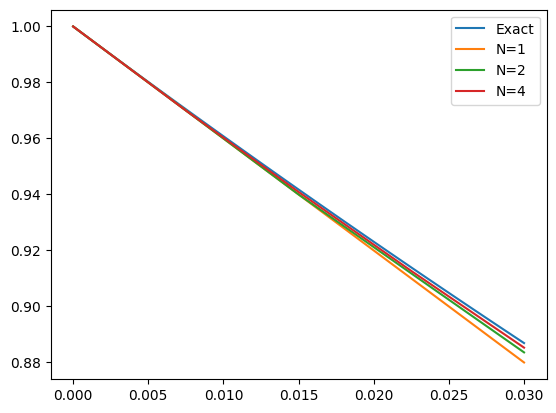

In [19]:
def f(x,y):
    return x**2-4*y

def exact(x):
    return 31/32*np.exp(-4*x) + 1/4*x**2 - 1/8*x + 1/32

def euler(f, x0, y0, xStop, n):
    h = (xStop-x0)/n
    xs = [x0]
    ys = [y0]
    for i in range(n):
        ys.append(ys[-1]+h*f(xs[-1], ys[-1]))
        xs.append(xs[-1]+h)
    return xs, ys

xs = np.linspace(0, 0.03, 100)
plt.plot(xs, exact(xs), label='Exact')
plt.plot(np.linspace(0,0.03,2), euler(f, 0, 1, 0.03, 1)[1], label='N=1')
plt.plot(np.linspace(0,0.03,3), euler(f, 0, 1, 0.03, 2)[1], label='N=2')
plt.plot(np.linspace(0,0.03,5), euler(f, 0, 1, 0.03, 4)[1], label='N=4')
plt.legend()
euler(f, 0, 1, 0.03, 1)[1][-1]-exact(0.03), euler(f, 0, 1, 0.03, 2)[1][-1]-exact(0.03), euler(f, 0, 1, 0.03, 4)[1][-1]-exact(0.03)

### 2. Metoda Runge-Kutta drugiego rzędu

(0.0002775769302537645, 6.635407400379378e-05, 1.622151381408532e-05)

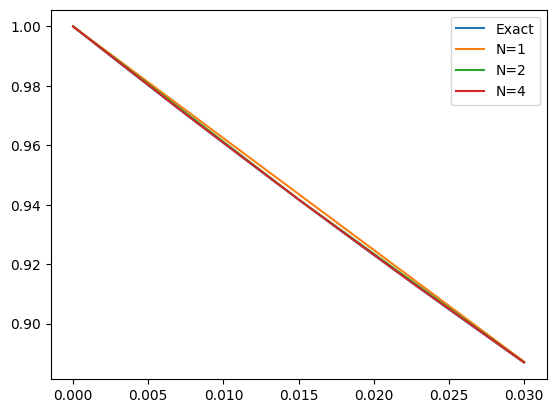

In [20]:
def soRungeKutta(f, x0, y0, xStop, n):
    h = (xStop-x0)/n
    xs = [x0]
    ys = [y0]
    for i in range(n):
        k1 = h*f(xs[-1], ys[-1])
        k2 = h*f(xs[-1]+h/2, ys[-1]+k1/2)
        ys.append(ys[-1]+k2)
        xs.append(xs[-1]+h)
    return xs, ys

plt.plot(xs, exact(xs), label='Exact')
plt.plot(np.linspace(0,0.03,2), soRungeKutta(f, 0, 1, 0.03, 1)[1], label='N=1')
plt.plot(np.linspace(0,0.03,3), soRungeKutta(f, 0, 1, 0.03, 2)[1], label='N=2')
plt.plot(np.linspace(0,0.03,5), soRungeKutta(f, 0, 1, 0.03, 4)[1], label='N=4')
plt.legend()
soRungeKutta(f, 0, 1, 0.03, 1)[1][-1]-exact(0.03), soRungeKutta(f, 0, 1, 0.03, 2)[1][-1]-exact(0.03), soRungeKutta(f, 0, 1, 0.03, 4)[1][-1]-exact(0.03)

### 3. Metoda Runge-Kutty czwartego rzędu

(2.0503025377482942e-07, 1.2198130394658335e-08, 7.438453186736638e-10)

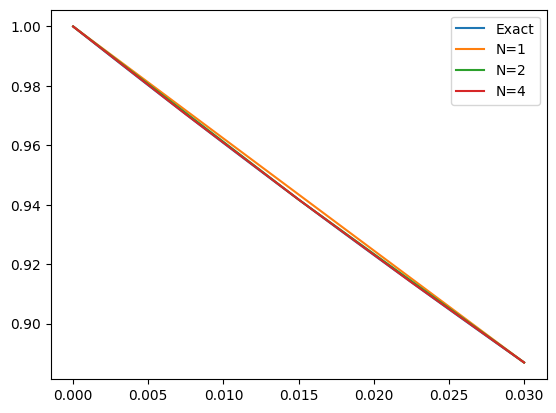

In [21]:
def foRungeKutta(f, x0, y0, xStop, n):
    h = (xStop-x0)/n
    xs = [x0]
    ys = [y0]
    for i in range(n):
        k1 = f(xs[-1], ys[-1])
        k2 = f(xs[-1]+h/2, ys[-1]+h*k1/2)
        k3 = f(xs[-1]+h/2, ys[-1]+h*k2/2)
        k4 = f(xs[-1]+h, ys[-1]+h*k3)
        ys.append(ys[-1] + h*(k1+2*k2+2*k3+k4)/6)
        xs.append(xs[-1]+h)
    return xs, ys

plt.plot(xs, exact(xs), label='Exact')
plt.plot(np.linspace(0,0.03,2), foRungeKutta(f, 0, 1, 0.03, 1)[1], label='N=1')
plt.plot(np.linspace(0,0.03,3), foRungeKutta(f, 0, 1, 0.03, 2)[1], label='N=2')
plt.plot(np.linspace(0,0.03,5), foRungeKutta(f, 0, 1, 0.03, 4)[1], label='N=4')
plt.legend()
foRungeKutta(f, 0, 1, 0.03, 1)[1][-1]-exact(0.03), foRungeKutta(f, 0, 1, 0.03, 2)[1][-1]-exact(0.03), foRungeKutta(f, 0, 1, 0.03, 4)[1][-1]-exact(0.03)